# Flight Delays Machine Learning Project

## Importing libraries und data

In [1]:
import pandas as pd
import math
import sklearn
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
#Import Data from CSV-file
flights = pd.read_csv('flights.csv')
flights.head()

,Unnamed: 0,MONTH,DAY,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,ARRIVAL_DELAY,CANCELLED
0,5712760,12,25,5,LAS,DCA,6,-25.0,0
1,5712761,12,25,5,LAX,DTW,10,-48.0,0
2,5712762,12,25,5,LAX,DFW,10,-24.0,0
3,5712763,12,25,5,DEN,ATL,15,-18.0,0
4,5712764,12,25,5,SFO,CLT,15,-34.0,0


## Data preparation

In [3]:
#Selection of range 32-42 to check data cleaning throughout the next steps 

flights.iloc [32:43]

,Unnamed: 0,MONTH,DAY,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,ARRIVAL_DELAY,CANCELLED
32,5712792,12,25,5,ANC,SEA,45,-38.0,0
33,5712793,12,25,5,LAS,MSP,46,-16.0,0
34,5712794,12,25,5,DEN,PHL,49,-28.0,0
35,5712795,12,25,5,PDX,MSP,50,-18.0,0
36,5712796,12,25,5,LAX,CLT,50,-26.0,0
37,5712797,12,25,5,SLC,ATL,55,84.0,0
38,5712798,12,25,5,LAS,IAH,55,-6.0,0
39,5712799,12,25,5,LAX,ORD,55,-43.0,0
40,5712800,12,25,5,LAX,DFW,55,-10.0,0
41,5712801,12,25,5,LAS,CLT,55,-4.0,0


In [4]:
#check for missing values 

flights.isnull().sum()

Unnamed: 0               0
MONTH                    0
DAY                      0
DAY_OF_WEEK              0
ORIGIN_AIRPORT           0
DESTINATION_AIRPORT      0
SCHEDULED_DEPARTURE      0
ARRIVAL_DELAY          192
CANCELLED                0
dtype: int64

In [5]:
#Reduce DataFrame by keeping only relevant data

df = flights[["MONTH", "DAY", "DAY_OF_WEEK", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "SCHEDULED_DEPARTURE", "ARRIVAL_DELAY","CANCELLED"]]
df.isnull().sum()

MONTH                    0
DAY                      0
DAY_OF_WEEK              0
ORIGIN_AIRPORT           0
DESTINATION_AIRPORT      0
SCHEDULED_DEPARTURE      0
ARRIVAL_DELAY          192
CANCELLED                0
dtype: int64

In [6]:
#Assing 10 to every missing value as they represent canceled flights
#Number 10 is chosen as our limit, every flight with a delay ≥ 10 will be treated as late

df = df.fillna({"ARRIVAL_DELAY": 10})

In [7]:
#Add new column "effective delay" ≥ 10 min = 1 as dummy

df.loc[df.ARRIVAL_DELAY >= 10, 'EFFECTIVE_DELAY'] = '1' 
df.loc[df.ARRIVAL_DELAY < 10, 'EFFECTIVE_DELAY'] = '0' 

In [8]:
#Check modifications have been assigned correctly

df.iloc [32:43]

,MONTH,DAY,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,ARRIVAL_DELAY,CANCELLED,EFFECTIVE_DELAY
32,12,25,5,ANC,SEA,45,-38.0,0,0
33,12,25,5,LAS,MSP,46,-16.0,0,0
34,12,25,5,DEN,PHL,49,-28.0,0,0
35,12,25,5,PDX,MSP,50,-18.0,0,0
36,12,25,5,LAX,CLT,50,-26.0,0,0
37,12,25,5,SLC,ATL,55,84.0,0,1
38,12,25,5,LAS,IAH,55,-6.0,0,0
39,12,25,5,LAX,ORD,55,-43.0,0,0
40,12,25,5,LAX,DFW,55,-10.0,0,0
41,12,25,5,LAS,CLT,55,-4.0,0,0


In [9]:
#Drop further now redundant columns

df = df.drop(columns= ["ARRIVAL_DELAY","MONTH","DAY","DAY_OF_WEEK","CANCELLED"])

In [10]:
#Reduce dataframe to have only the 10 busiest airports in the United States as destination and origin airport

df2 = df[(df.DESTINATION_AIRPORT == "ATL")|(df.DESTINATION_AIRPORT == "ORD")|(df.DESTINATION_AIRPORT == "LAX")|(df.DESTINATION_AIRPORT == "DFW")|(df.DESTINATION_AIRPORT == "JFK")|(df.DESTINATION_AIRPORT == "DEN")|(df.DESTINATION_AIRPORT == "SFO")|(df.DESTINATION_AIRPORT == "LAS")|(df.DESTINATION_AIRPORT == "PHX")|(df.DESTINATION_AIRPORT == "IAH")]
df3 = df2[(df2.ORIGIN_AIRPORT == "ATL")|(df2.ORIGIN_AIRPORT == "ORD")|(df2.ORIGIN_AIRPORT == "LAX")|(df2.ORIGIN_AIRPORT == "DFW")|(df2.ORIGIN_AIRPORT == "JFK")|(df2.ORIGIN_AIRPORT == "DEN")|(df2.ORIGIN_AIRPORT == "SFO")|(df2.ORIGIN_AIRPORT == "LAS")|(df2.ORIGIN_AIRPORT == "PHX")|(df2.ORIGIN_AIRPORT == "IAH")]

In [11]:
#Quantization of departure hours to 24 values (hours) to improve accuracy in machine learning

for index, row  in df3.iterrows():
    df3.loc[index, "SCHEDULED_DEPARTURE"] = math.floor(row["SCHEDULED_DEPARTURE"]/100)
    

/Users/calvin/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [12]:
#Create dummy variables for the Airports

df3 = pd.get_dummies (df3, columns= ["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"])

In [13]:
#Check modifications have been assigned correctly

df3.iloc [32:43]

,SCHEDULED_DEPARTURE,EFFECTIVE_DELAY,ORIGIN_AIRPORT_ATL,ORIGIN_AIRPORT_DEN,ORIGIN_AIRPORT_DFW,ORIGIN_AIRPORT_IAH,ORIGIN_AIRPORT_JFK,ORIGIN_AIRPORT_LAS,ORIGIN_AIRPORT_LAX,ORIGIN_AIRPORT_ORD,...,DESTINATION_AIRPORT_ATL,DESTINATION_AIRPORT_DEN,DESTINATION_AIRPORT_DFW,DESTINATION_AIRPORT_IAH,DESTINATION_AIRPORT_JFK,DESTINATION_AIRPORT_LAS,DESTINATION_AIRPORT_LAX,DESTINATION_AIRPORT_ORD,DESTINATION_AIRPORT_PHX,DESTINATION_AIRPORT_SFO
212,5,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
216,5,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
226,5,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
236,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
276,5,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
294,6,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
322,6,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
326,6,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
331,6,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
353,6,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


## Build machine learning model

In [14]:
#train-test split of dataframe in 70%/30% ratio

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df3.drop('EFFECTIVE_DELAY', axis=1), df3['EFFECTIVE_DELAY'], test_size=0.3, random_state = 10)

In [15]:
#DataFrame containing the feature columns used for training

train_x.shape

(830, 21)

In [16]:
#DataFrame containing the feature columns used for testing

test_x.shape

(357, 21)

In [17]:
#Create a RandomForestClassifier object and train it

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=10)
model.fit(train_x, train_y)

/Users/calvin/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

## Accuracy Measurements

In [18]:
#Measure mean accuracy of the model

predicted = model.predict(test_x)
model.score(test_x,test_y)

0.6722689075630253

In [19]:
#Measure accuracy of the classification model with ROC AUC score

from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)
roc_auc_score(test_y, probabilities [:,1])

0.6213269800014439

In [20]:
#Generate an error matrix to measure the amount of correctly or incorrectly classified answers

from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[198,  45],
       [ 72,  42]])

In [21]:
#Measure the precision of the model

from sklearn.metrics import precision_score
train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions, average="binary", pos_label="1")

0.900990099009901

In [22]:
#Recall score to measure ability of the classifier to find all the positive samples

from sklearn.metrics import recall_score
recall_score(train_y, train_predictions, average="binary", pos_label="1")

0.7878787878787878

## Visualize model output

Text(0, 0.5, 'True Positive Rate')

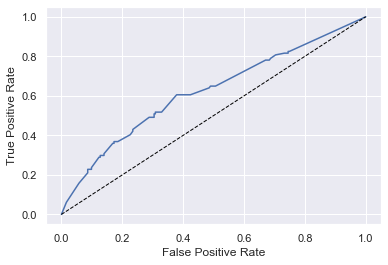

In [23]:
#Render roc curve to visualize accuracy of the classification model

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1], pos_label='1')
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Predict probability of on-time-arrival 

In [24]:
#Function to predict the likelihood of a flight arriving on time 

def predict_delay(scheduled_departure, origin_airport, destination_airport):
    from datetime import datetime

    try:
        scheduled_departure_parsed = datetime.strptime(scheduled_departure, "%H:%M")
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    hour = scheduled_departure_parsed.hour

    input = [{'SCHEDULED_DEPARTURE': hour,
              'ORIGIN_AIRPORT_ATL': 1 if origin_airport == 'ATL' else 0,
              'ORIGIN_AIRPORT_ORD': 1 if origin_airport == 'ORD' else 0,
              'ORIGIN_AIRPORT_LAX': 1 if origin_airport == 'LAX' else 0,
              'ORIGIN_AIRPORT_DFW': 1 if origin_airport == 'DFW' else 0,
              'ORIGIN_AIRPORT_JFK': 1 if origin_airport == 'JFK' else 0,
              'ORIGIN_AIRPORT_DEN': 1 if origin_airport == 'DEN' else 0,
              'ORIGIN_AIRPORT_SFO': 1 if origin_airport == 'SFO' else 0,
              'ORIGIN_AIRPORT_LAS': 1 if origin_airport == 'LAS' else 0,
              'ORIGIN_AIRPORT_PHX': 1 if origin_airport == 'PHX' else 0,
              'ORIGIN_AIRPORT_IAH': 1 if origin_airport == 'IAH' else 0,
              'DESTINATION_AIRPORT_ATL': 1 if destination_airport == 'ATL' else 0,
              'DESTINATION_AIRPORT__ORD': 1 if destination_airport == 'ORD' else 0,
              'DESTINATION_AIRPORT__LAX': 1 if destination_airport == 'LAX' else 0,
              'DESTINATION_AIRPORT__DFW': 1 if destination_airport == 'DFW' else 0,
              'DESTINATION_AIRPORT__JFK': 1 if destination_airport == 'JFK' else 0,
              'DESTINATION_AIRPORT__DEN': 1 if destination_airport == 'DEN' else 0,
              'DESTINATION_AIRPORT__SFO': 1 if destination_airport == 'SFO' else 0,
              'DESTINATION_AIRPORT__LAS': 1 if destination_airport == 'LAS' else 0,
              'DESTINATION_AIRPORT__PHX': 1 if destination_airport == 'PHX' else 0,
              'DESTINATION_AIRPORT__IAH': 1 if destination_airport == 'IAH' else 0 }]

    return model.predict_proba(pd.DataFrame(input))[0][0]

## Conversation bot for user input 

In [25]:
# Lists for conversation bot

greetings = ["hello", "hi", "hey", "greetings", "ciao", "salut", "hallo"]
greeting_responses = ["\nHello,", "\nHi,", "\nHey,", "\nGreetings,", "\nNice to see you here,"]
airport_list = ["ATL", "ORD", "LAX", "DFW", "JFK", "DEN", "SFO", "LAS", "PHX", "IAH"]
AIRPORT_QUESTIONS = ["do you want to see the available airports?", "do you want to take a look at the available airports?", "do you want to see our list of available airports?"]

In [26]:
#Function to return input

def ask_input(txt):
  return input(txt).split()

In [27]:
#Function for Yes or No 

def yes_or_no():
  answer_yes_or_no = input("Please answer by yes or no: ")
  while True:
    if answer_yes_or_no.lower() == "yes":
      return True
      break
    elif answer_yes_or_no.lower() == "no":
      return False
      break
    else:
      answer_yes_or_no = input("Oops, something went wrong here. Please only answer by yes or no! You may try again now: ")

In [28]:
#Function for bot greeting and call airport_possibilities 

def random_greeting(txt):
    i = 0
    sentence = ask_input(txt)
    for s in range(len(sentence)):
        if sentence[s].lower() in greetings:
            greeting_answer = random.choice(greeting_responses)
            greeting_answer += " welcome to our flight delay calculator. Thanks to us you'll be home on time for Christmas! "
            print(greeting_answer)
            airport_possibilities()
            i = 1
            break
    if i == 0:
        print("\nOops, our bot doesn't work unless greeted")
        random_greeting("To find out which plane to take to be home on time for Christmas, please try again with a greeting: ")

In [29]:
#Function to display airport_list and call airport_departure

def airport_possibilities():
  print("\nBefore we can calculate your delay, " + random.choice(AIRPORT_QUESTIONS))
  if yes_or_no():
    print("\nThe available airports are: ", ", ".join(airport_list))
    airport_departure("Please enter the airport you are departing from : ")
  else:
    print("\nOkay")
    airport_departure("Please enter the airport you are departing from : ")

In [30]:
#Function to check whether airport_departure is in list and call airport_arrival  

def airport_departure(chosen_airport_departure):
    global str_chosen_airport_departure
    i = 0
    chosen_airport_departure = ask_input(chosen_airport_departure)
    for word in chosen_airport_departure:
        if word.upper() in airport_list:
            airport_arrival("\nPlease enter the airport you are going to :")
            i = 1
            str_chosen_airport_departure = ' '.join([str(elem) for elem in chosen_airport_departure])
            break
    if i == 0:
        print("\nSorry, this airport is not available for our machine learning. Make sure you write the name correctly!")
        airport_departure("Try to enter the right name this time: ")

In [31]:
#Function to check whether airport_arrival is in list

def airport_arrival(chosen_airport_arrival):
    global str_chosen_airport_arrival
    i = 0
    chosen_airport_arrival = ask_input(chosen_airport_arrival)
    for word in chosen_airport_arrival:
        if word.upper() in airport_list:           
            i = 1
            str_chosen_airport_arrival = ' '.join([str(elem) for elem in chosen_airport_arrival])
            break
    if i == 0:
        print("\nSorry, this airport is not available for our machine learning. Make sure you write the name correctly!")
        airport_arrival("Try to enter the right name this time: ")

Welcome to our chatbot. Please greet him: nö

Oops, our bot doesn't work unless greeted
To find out which plane to take to be home on time for Christmas, please try again with a greeting: Hey

Nice to see you here, welcome to our flight delay calculator. Thanks to us you'll be home on time for Christmas! 

Before we can calculate your delay, do you want to take a look at the available airports?
Please answer by yes or no: yes

The available airports are:  ATL, ORD, LAX, DFW, JFK, DEN, SFO, LAS, PHX, IAH
Please enter the airport you are departing from : wrong

Sorry, this airport is not available for our machine learning. Make sure you wrote the name correctly!
Try to enter the right name this time: atl

Please enter the airport you are going to :wrong

Sorry, this airport is not available for our machine learning. Make sure you write the name correctly!
Try to enter the right name this time: ord

Great, you have chosen to go from ATL to ORD. Since Christmas is a busy time at the airpor

(0.0, 1.0)

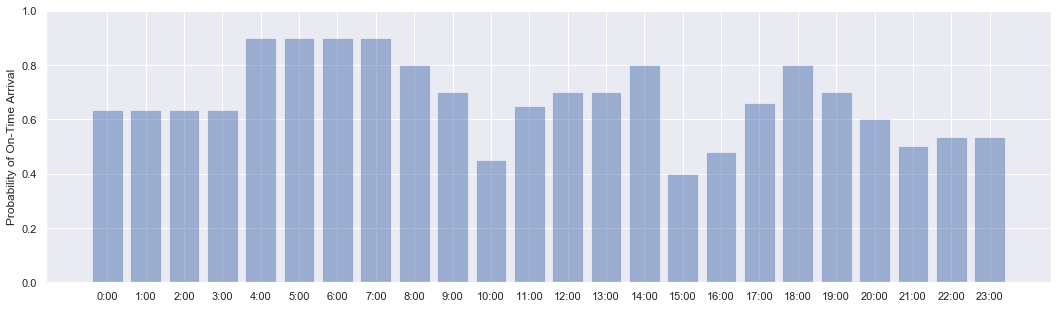

In [32]:
#Start conversation bot

random_greeting("Welcome to our chatbot. Please greet him: ")

print("\nGreat, you have chosen to go from %s to %s. Since Christmas is a busy time at the airport we predicted the probability of on-time-arrival for your trip for every hour. Choose wisely and have a safe trip. Merry Christmas!" %(str_chosen_airport_departure.upper(), str_chosen_airport_arrival.upper()))
labels = ('0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00')
values = (predict_delay("0:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("1:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("2:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("3:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("4:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("5:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("6:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("7:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("8:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("9:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("10:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("11:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("12:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("13:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("14:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("15:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("16:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("17:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("18:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("19:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("20:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("21:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("22:00", str_chosen_airport_departure, str_chosen_airport_arrival),
         predict_delay("22:00", str_chosen_airport_departure, str_chosen_airport_arrival))    
alabels = np.arange(len(labels))

f, ax = plt.subplots(figsize=(18,5))
plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))